<a href="https://colab.research.google.com/drive/1DV6IJZVShaInN14j_cRSYvR7j6IsHJ7C?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

100%|██████████| 3.69G/3.69G [00:48<00:00, 81.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [ ]:
/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2

In [ ]:
import pandas as pd
data = pd.read_csv('/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv')

In [ ]:
data

,101,URTI
0,102,Healthy
1,103,Asthma
2,104,COPD
3,105,URTI
4,106,COPD
...,...,...
120,222,COPD
121,223,COPD
122,224,Healthy
123,225,Healthy


In [ ]:
import pandas as pd

label_csv_path = "/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv"
df_labels = pd.read_csv(label_csv_path, header=None, names=["Patient_ID", "Diagnosis"])
patient_labels = dict(zip(df_labels["Patient_ID"].astype(str), df_labels["Diagnosis"]))

print("Contoh label:", list(patient_labels.items())[:5])


Contoh label: [('101', 'URTI'), ('102', 'Healthy'), ('103', 'Asthma'), ('104', 'COPD'), ('105', 'URTI')]


## Langkah 1.1: Load label diagnosis

In [ ]:
import pandas as pd

# Path to patient diagnosis CSV
csv_path = "/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv"

# Load CSV
df = pd.read_csv(csv_path, header=None, names=["Patient_ID", "Diagnosis"])

# Convert to dictionary {Patient_ID: Diagnosis}
patient_labels = dict(zip(df["Patient_ID"].astype(str), df["Diagnosis"]))

# Display first few mappings
print(list(patient_labels.items())[:10])

[('101', 'URTI'), ('102', 'Healthy'), ('103', 'Asthma'), ('104', 'COPD'), ('105', 'URTI'), ('106', 'COPD'), ('107', 'COPD'), ('108', 'LRTI'), ('109', 'COPD'), ('110', 'COPD')]


In [ ]:
# prompt: cek jumlah dataset per kelas

# Rename the first column to 'Patient_ID'
data = data.rename(columns={data.columns[0]: 'Patient_ID'})

# Menggabungkan informasi label ke dalam DataFrame data
data['Diagnosis'] = data['Patient_ID'].astype(str).map(patient_labels)

# Menghitung jumlah dataset per kelas (Diagnosis)
diagnosis_counts = data['Diagnosis'].value_counts()

print("\nJumlah dataset per kelas (Diagnosis):")
display(diagnosis_counts)


Jumlah dataset per kelas (Diagnosis):


,count
Diagnosis,
COPD,64
Healthy,26
URTI,13
Bronchiectasis,7
Bronchiolitis,6
Pneumonia,6
LRTI,2
Asthma,1


## Langkah 1.2: Load file audio, ekstrak fitur MFCC

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.io.wavfile import write

# Paths
audio_folder = "/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files"
output_folder = "/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/segmented_audio"
os.makedirs(output_folder, exist_ok=True)

# Function to extract segments
def extract_segments(audio_folder, output_folder, patient_labels):
    for file in os.listdir(audio_folder):
        if file.endswith(".wav"):
            audio_path = os.path.join(audio_folder, file)
            txt_path = os.path.join(audio_folder, file.replace(".wav", ".txt"))

            # Extract patient ID from filename (e.g., "101_1b1_Al_sc_Meditron.wav" → "101")
            patient_id = file.split("_")[0]

            # Get label from patient metadata
            label = patient_labels.get(patient_id, "Unknown")  # Default to "Unknown" if not found

            # Load audio file
            y, sr = librosa.load(audio_path, sr=None)

            if os.path.exists(txt_path):
                df = pd.read_csv(txt_path, sep="\t", header=None, names=["Start", "End", "Wheeze", "Crackle"])

                for index, row in df.iterrows():
                    start_time, end_time = row["Start"], row["End"]
                    start_sample = int(start_time * sr)
                    end_sample = int(end_time * sr)

                    # Extract audio segment
                    segment = y[start_sample:end_sample]

                    # Save segment as a new .wav file
                    segment_filename = f"{patient_id}_seg_{index}_{label}.wav"
                    write(os.path.join(output_folder, segment_filename), sr, segment)

    print("Segmentation complete. Files saved to:", output_folder)

# Run the function
extract_segments(audio_folder, output_folder, patient_labels)

Segmentation complete. Files saved to: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/segmented_audio


In [ ]:
import os
import librosa
import numpy as np

audio_folder = "/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/segmented_audio"
target_sr = 16000
duration = 3  # dalam detik

features = []
labels = []

for file in os.listdir(audio_folder):
    if file.endswith(".wav"):
        file_path = os.path.join(audio_folder, file)
        patient_id = file.split("_")[0]
        label = patient_labels.get(patient_id, "Unknown")

        try:
            y, sr = librosa.load(file_path, sr=target_sr, duration=duration)

            # Pad/trim supaya panjangnya konsisten
            if len(y) < target_sr * duration:
                y = np.pad(y, (0, max(0, target_sr * duration - len(y))), mode='constant')
            else:
                y = y[:target_sr * duration]

            # Ekstraksi fitur MFCC
            mfccs = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=40)
            mfccs = np.mean(mfccs.T, axis=0)  # dirata-rata per kolom

            features.append(mfccs)
            labels.append(label)

        except Exception as e:
            print("Gagal memproses:", file_path, e)


Contoh file audio: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/segmented_audio/218_seg_15_COPD.wav


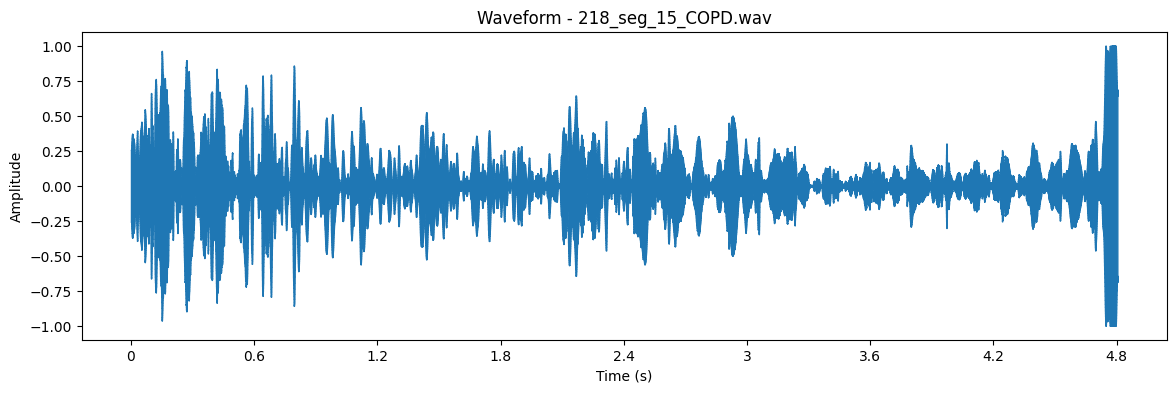

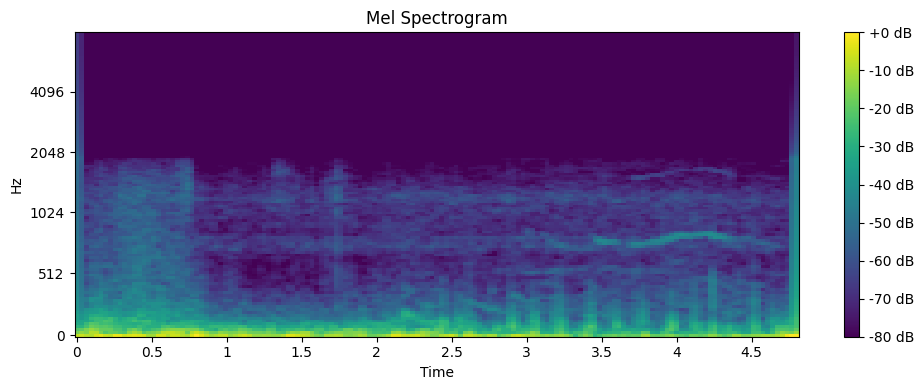

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

# Ambil satu contoh file audio
example_file = None
for file in os.listdir(audio_folder):
    if file.endswith(".wav"):
        example_file = os.path.join(audio_folder, file)
        break

print("Contoh file audio:", example_file)

# Load audio
y, sr = librosa.load(example_file, sr=16000)

# 1. Tampilkan waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform - ' + os.path.basename(example_file))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# 2. Tampilkan Mel Spectrogram
plt.figure(figsize=(10, 4))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# 3. Tampilkan player audio
ipd.Audio(example_file)


## Langkah 1.3: Encode label menjadi numerik

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = to_categorical(label_encoder.fit_transform(labels))

X = np.array(features)
y = y_encoded

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Kelas:", label_encoder.classes_)


Shape X: (1241, 40)
Shape y: (1241, 8)
Kelas: ['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI'
 'Pneumonia' 'URTI']


## 🧠 Tahap 2: Membangun Arsitektur Model CNN

In [ ]:
X = np.expand_dims(X, axis=-1)
print("Input shape untuk CNN:", X.shape)


Input shape untuk CNN: (1241, 40, 1)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (992, 40, 1)
Test shape: (249, 40, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40, 128)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 40, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,008 (593.78 KB)

 Trainable params: 151,112 (590.28 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2080 - loss: 2.0772

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.2108 - loss: 2.0732 - val_accuracy: 0.4578 - val_loss: 1.9967
Epoch 2/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4575 - loss: 1.6973

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4595 - loss: 1.6883 - val_accuracy: 0.5060 - val_loss: 1.6762
Epoch 3/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5272 - loss: 1.4278

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5285 - loss: 1.4250 - val_accuracy: 0.5341 - val_loss: 1.5711
Epoch 4/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5600 - loss: 1.2678

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5593 - loss: 1.2693 - val_accuracy: 0.5341 - val_loss: 1.4788
Epoch 5/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5834 - loss: 1.2136

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5843 - loss: 1.2111 - val_accuracy: 0.5823 - val_loss: 1.3234
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6091 - loss: 1.1550 - val_accuracy: 0.5582 - val_loss: 1.3515
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5984 - loss: 1.1752

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5984 - loss: 1.1750 - val_accuracy: 0.6024 - val_loss: 1.2355
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5781 - loss: 1.1935 - val_accuracy: 0.5221 - val_loss: 1.3288
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6396 - loss: 1.1132 - val_accuracy: 0.4940 - val_loss: 1.3878
Epoch 10/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6221 - loss: 1.0589

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6210 - loss: 1.0616 - val_accuracy: 0.6225 - val_loss: 1.1438
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6118 - loss: 1.0672

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6115 - loss: 1.0679 - val_accuracy: 0.6225 - val_loss: 1.1436
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6036 - loss: 1.1045

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6038 - loss: 1.1041 - val_accuracy: 0.6265 - val_loss: 1.1278
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6179 - loss: 1.0630

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6179 - loss: 1.0621 - val_accuracy: 0.6667 - val_loss: 0.9909
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6004 - loss: 1.0516 - val_accuracy: 0.6225 - val_loss: 1.1163
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6008 - loss: 1.0158 - val_accuracy: 0.6586 - val_loss: 1.0503
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5950 - loss: 1.0413 - val_accuracy: 0.6345 - val_loss: 1.0226
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6032 - loss: 1.1096 - val_accuracy: 0.6305 - val_loss: 1.0563
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6111 - loss: 1.0178 - val_accuracy: 0.6466 - val_loss: 0.9977
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6478 - loss: 0.9626 - val_accuracy: 0.6506 - val_loss: 1.0063
Epoch 20/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6379 - loss: 0.9432

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6372 - loss: 0.9457 - val_accuracy: 0.6747 - val_loss: 0.9014
Epoch 21/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6465 - loss: 0.9883

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6469 - loss: 0.9860 - val_accuracy: 0.6827 - val_loss: 0.8849
Epoch 22/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6339 - loss: 0.9676

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6346 - loss: 0.9667 - val_accuracy: 0.6667 - val_loss: 0.8617
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6506 - loss: 0.9012

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6506 - loss: 0.9023 - val_accuracy: 0.6627 - val_loss: 0.8575
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6555 - loss: 0.9002

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6549 - loss: 0.9007 - val_accuracy: 0.6747 - val_loss: 0.8350
Epoch 25/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6895 - loss: 0.8577

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6880 - loss: 0.8606 - val_accuracy: 0.7028 - val_loss: 0.8003
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6723 - loss: 0.9554 - val_accuracy: 0.6867 - val_loss: 0.8467
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6841 - loss: 0.8152 - val_accuracy: 0.6867 - val_loss: 0.8110
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7068 - loss: 0.7877 - val_accuracy: 0.6827 - val_loss: 0.8072
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6969 - loss: 0.8041 - val_accuracy: 0.7229 - val_loss: 0.8051
Epoch 30/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6709 - loss: 0.8836

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6731 - loss: 0.8804 - val_accuracy: 0.7269 - val_loss: 0.7607
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6720 - loss: 0.8364 - val_accuracy: 0.6948 - val_loss: 0.7622
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6893 - loss: 0.7897

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6889 - loss: 0.7906 - val_accuracy: 0.7229 - val_loss: 0.7506
Epoch 33/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6826 - loss: 0.8621

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6848 - loss: 0.8563 - val_accuracy: 0.7149 - val_loss: 0.7261
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7069 - loss: 0.8149 - val_accuracy: 0.7349 - val_loss: 0.7273
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7124 - loss: 0.7553

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7119 - loss: 0.7564 - val_accuracy: 0.7671 - val_loss: 0.6955
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7147 - loss: 0.7651 - val_accuracy: 0.7189 - val_loss: 0.7304
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7068 - loss: 0.7964 - val_accuracy: 0.7430 - val_loss: 0.7233
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7009 - loss: 0.8304 - val_accuracy: 0.7470 - val_loss: 0.7037
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7064 - loss: 0.7764 - val_accuracy: 0.7390 - val_loss: 0.7302
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7321 - loss: 0.7192 - val_accuracy: 0.7390 - val_loss: 0.7194
Epoch 41/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6956 - loss: 0.8093

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6984 - loss: 0.8028 - val_accuracy: 0.7590 - val_loss: 0.6868
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7252 - loss: 0.7525 - val_accuracy: 0.7590 - val_loss: 0.7053
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7315 - loss: 0.7276

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7319 - loss: 0.7273 - val_accuracy: 0.7550 - val_loss: 0.6716
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7317 - loss: 0.6931 - val_accuracy: 0.7510 - val_loss: 0.7008
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7373 - loss: 0.7005 - val_accuracy: 0.7550 - val_loss: 0.7214
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7597 - loss: 0.6868

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7593 - loss: 0.6879 - val_accuracy: 0.7510 - val_loss: 0.6700
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7475 - loss: 0.6866

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7474 - loss: 0.6865 - val_accuracy: 0.7952 - val_loss: 0.6540
Epoch 48/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7695 - loss: 0.6924

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7685 - loss: 0.6922 - val_accuracy: 0.7671 - val_loss: 0.6387
Epoch 49/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7202 - loss: 0.7160

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7208 - loss: 0.7153 - val_accuracy: 0.7550 - val_loss: 0.6266
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7127 - loss: 0.6955 - val_accuracy: 0.7631 - val_loss: 0.6390
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7572 - loss: 0.6237

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7568 - loss: 0.6242 - val_accuracy: 0.7912 - val_loss: 0.6216
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6805

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7499 - loss: 0.6797 - val_accuracy: 0.7791 - val_loss: 0.5901
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7426 - loss: 0.6678

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7431 - loss: 0.6668 - val_accuracy: 0.7871 - val_loss: 0.5778
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7594 - loss: 0.6415 - val_accuracy: 0.7751 - val_loss: 0.5937
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7574 - loss: 0.6705

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7572 - loss: 0.6703 - val_accuracy: 0.8072 - val_loss: 0.5516
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7408 - loss: 0.6671 - val_accuracy: 0.7711 - val_loss: 0.6228
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7480 - loss: 0.6280 - val_accuracy: 0.7992 - val_loss: 0.5571
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7774 - loss: 0.5869 - val_accuracy: 0.7912 - val_loss: 0.5649
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7616 - loss: 0.6380 - val_accuracy: 0.8112 - val_loss: 0.5614
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7739 - loss: 0.6036

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7730 - loss: 0.6053 - val_accuracy: 0.8273 - val_loss: 0.5331
Epoch 61/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7710 - loss: 0.6383

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7706 - loss: 0.6385 - val_accuracy: 0.8514 - val_loss: 0.5103
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8061 - loss: 0.5776 - val_accuracy: 0.8193 - val_loss: 0.5503
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7721 - loss: 0.6209 - val_accuracy: 0.7992 - val_loss: 0.5910
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7863 - loss: 0.5866 - val_accuracy: 0.8032 - val_loss: 0.5736
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8105 - loss: 0.5518 - val_accuracy: 0.8032 - val_loss: 0.5670
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7811 - loss: 0.5659 - val_accuracy: 0.8193 - val_loss: 0.5439
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7977 - loss: 0.5459 - val_accuracy: 0.7711 - val_loss: 0.5912
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7850 - loss: 0.5890 - val_accuracy: 0.8273 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8249 - loss: 0.5230 - val_accuracy: 0.8394 - val_loss: 0.4988
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7926 - loss: 0.5378 - val_accuracy: 0.8112 - val_loss: 0.5166
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7783 - loss: 0.6029 - val_accuracy: 0.8353 - val_loss: 0.5354
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8004 - loss: 0.5327 - val_accuracy: 0.8434 - val_loss: 0.5141
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7990 - loss: 0.5252

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7988 - loss: 0.5258 - val_accuracy: 0.8474 - val_loss: 0.4751
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8072 - loss: 0.5244 - val_accuracy: 0.8554 - val_loss: 0.4777
Epoch 77/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7934 - loss: 0.5452

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7934 - loss: 0.5464 - val_accuracy: 0.8554 - val_loss: 0.4654
Epoch 78/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7839 - loss: 0.5822

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7848 - loss: 0.5804 - val_accuracy: 0.8313 - val_loss: 0.4625
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7864 - loss: 0.5589 - val_accuracy: 0.8434 - val_loss: 0.4652
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8019 - loss: 0.5253 - val_accuracy: 0.8153 - val_loss: 0.5297
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8044 - loss: 0.5266

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8046 - loss: 0.5256 - val_accuracy: 0.8273 - val_loss: 0.4517
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8260 - loss: 0.4977 - val_accuracy: 0.8353 - val_loss: 0.4919
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8094 - loss: 0.4906 - val_accuracy: 0.8394 - val_loss: 0.4931
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8237 - loss: 0.5070 - val_accuracy: 0.8554 - val_loss: 0.4555
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8427 - loss: 0.4482 - val_accuracy: 0.8434 - val_loss: 0.4802
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8195 - loss: 0.4860 - val_accuracy: 0.8554 - val_loss: 0.4773
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8365 - loss: 0.4847

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8362 - loss: 0.4844 - val_accuracy: 0.8715 - val_loss: 0.4498
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7959 - loss: 0.5584 - val_accuracy: 0.8394 - val_loss: 0.4620
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8179 - loss: 0.4760 - val_accuracy: 0.8755 - val_loss: 0.4546
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8537 - loss: 0.4151 - val_accuracy: 0.8353 - val_loss: 0.4727
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7894 - loss: 0.5789 - val_accuracy: 0.8434 - val_loss: 0.4776
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8182 - loss: 0.4755

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8182 - loss: 0.4758 - val_accuracy: 0.8715 - val_loss: 0.4471
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8130 - loss: 0.5108

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8131 - loss: 0.5104 - val_accuracy: 0.8594 - val_loss: 0.4190
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8336 - loss: 0.4609 - val_accuracy: 0.8514 - val_loss: 0.4370
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8284 - loss: 0.4753 - val_accuracy: 0.8594 - val_loss: 0.4211
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8386 - loss: 0.4695 - val_accuracy: 0.8635 - val_loss: 0.4262
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8388 - loss: 0.4709 - val_accuracy: 0.8594 - val_loss: 0.4309
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8510 - loss: 0.4195 - val_accuracy: 0.8554 - val_loss: 0.4571
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8449 - loss: 0.4456 - val_accuracy: 0.8635 - val_loss: 0.4580
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8640 - loss: 0.3765 - val_accuracy: 0.8554

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Akurasi test: {acc*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8841 - loss: 0.3529
Akurasi test: 87.55%


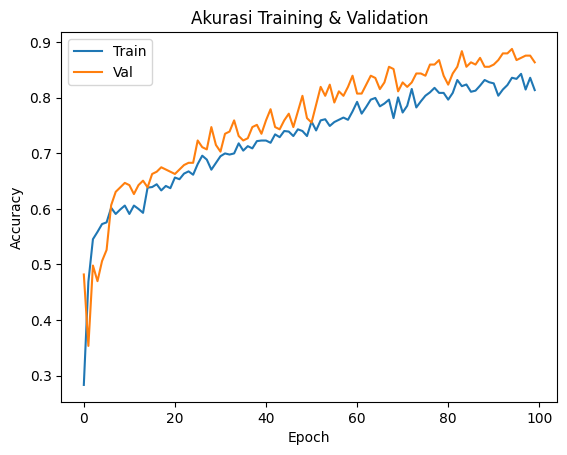

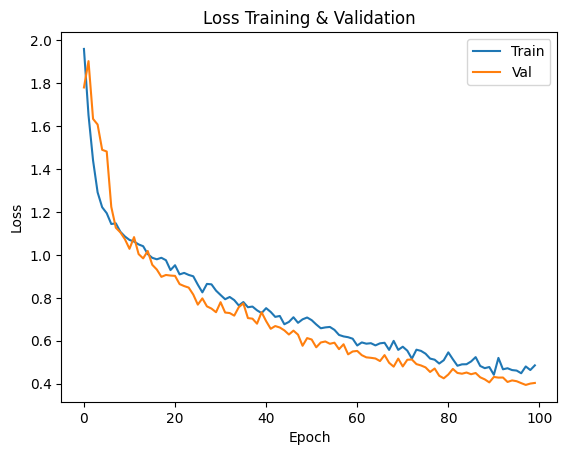

In [ ]:
import matplotlib.pyplot as plt

# Akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
import numpy as np

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class names
class_names = label_encoder.classes_

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
# Use average='weighted' to account for label imbalance
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n--- Model Performance Metrics ---")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision (Weighted): {precision:.2f}")
print(f"F1 Score (Weighted): {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

--- Model Performance Metrics ---
Accuracy: 87.55%
Precision (Weighted): 0.88
F1 Score (Weighted): 0.88

Classification Report:
                precision    recall  f1-score   support

        Asthma       0.50      1.00      0.67         1
Bronchiectasis       1.00      1.00      1.00         9
 Bronchiolitis       0.68      0.81      0.74        16
          COPD       0.97      0.93      0.95       126
       Healthy       0.79      0.90      0.84        50
          LRTI       0.50      0.33      0.40         6
     Pneumonia       0.82      0.82      0.82        11
          URTI       0.81      0.73      0.77        30

      accuracy                           0.88       249
     macro avg       0.76      0.82      0.77       249
  weighted avg       0.88      0.88      0.88       249



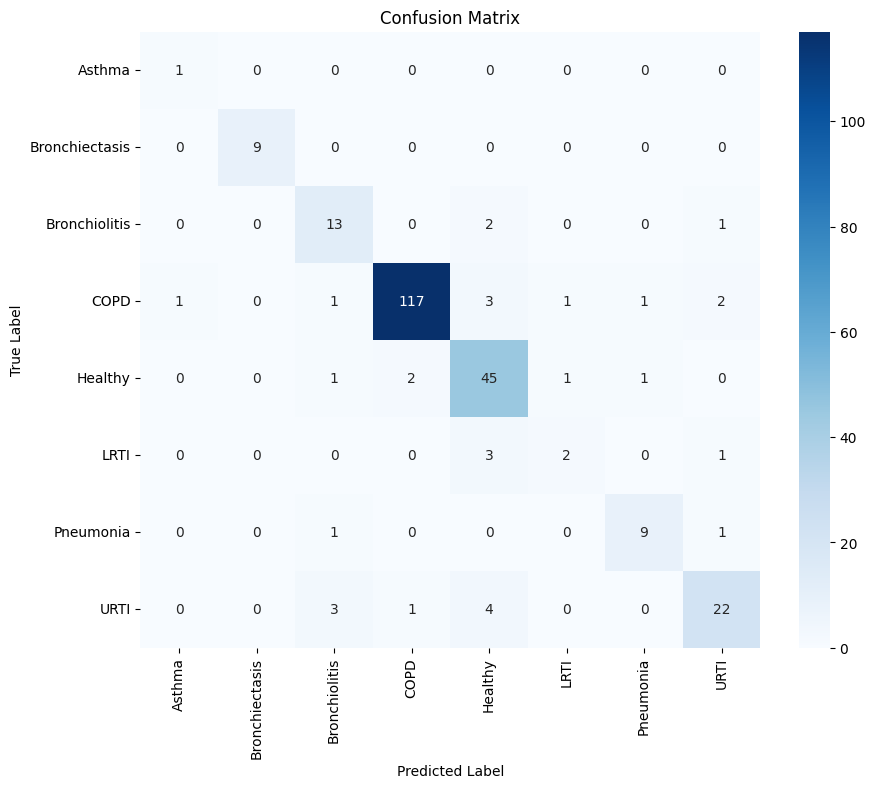

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
